In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.base import TransformerMixin
# from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix, accuracy_score
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
sns.set()

## Data Preview & Visualization

From the data preview, all the features and labels are found to be categorical

From the heatmap, it is found that the features 'maintenance', 'number_of_doors', 
'lug_boot_size' and 'safety' has almost no correlation with the label 'buying_price'

In [2]:
df = pd.read_csv(
        os.path.join(os.getcwd(), "..", "resource", "ml", "car.data"),
        names=["buying_price", "maintenance", "number_of_doors", "number_of_person", 
            "lug_boot_size", "safety", "class_value"],
        header=None
    )
df.head(10)

,buying_price,maintenance,number_of_doors,number_of_person,lug_boot_size,safety,class_value
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


In [3]:
label = "buying_price"
features = ["maintenance", "number_of_doors", 
            "lug_boot_size", "safety", "class_value"]
selected_features = ["class_value"]

In [4]:
# Examine the dataset
# All the features and label are categorical 
for column in [label]+features:
    print(f"Unique values of {column}: {df[column].unique().tolist()}")

Unique values of buying_price: ['vhigh', 'high', 'med', 'low']
Unique values of maintenance: ['vhigh', 'high', 'med', 'low']
Unique values of number_of_doors: ['2', '3', '4', '5more']
Unique values of lug_boot_size: ['small', 'med', 'big']
Unique values of safety: ['low', 'med', 'high']
Unique values of class_value: ['unacc', 'acc', 'vgood', 'good']


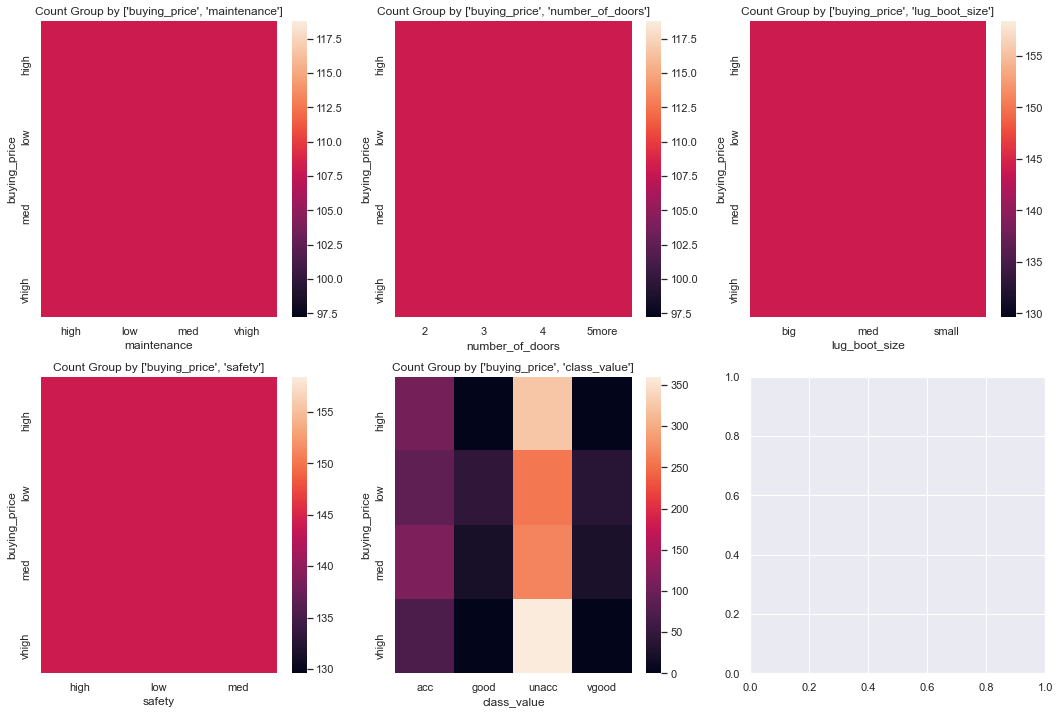

In [5]:
# From the heatmap, it can be told that the features 'maintenance', 'number_of_doors', 
# 'lug_boot_size' and 'safety' has almost no correlation with the label 'buying_price'

num_ax_row = 2
num_ax_col = len(features)//num_ax_row + 1
fig, axs = plt.subplots(num_ax_row, num_ax_col, figsize=(18, 12))

for i, feature in enumerate(features):
    groupby_columns = [label, feature]
    groupby_count = df[groupby_columns].groupby(groupby_columns).size().unstack().fillna(0)
    current_ax = axs[i//num_ax_col, i%num_ax_col]
    current_ax.set_title(f"Count Group by {groupby_columns}")
    sns.heatmap(groupby_count, ax=current_ax)

plt.show()

## Data Pre-processing

Data pre-processing is performed by first converting the categorical columns to respective numerical values and scaler is omitted due to categorical characteristic.

The data set is also split into training and validation set to prevent overfitting and validation purpose.

Two sets of data set are created based on different features and will be examined in the following section

In [6]:
# Convert categorical variable to numeric value
# No scaler is needed due to categorical characteristic

def preprocessing(df, features, label=None, encoders=dict(), test_size=0.3):
    if label:
        features_label_list = features + [label]
        processed_df = df[features_label_list]
        encoders = dict()
        for column in features_label_list:
            encoder = LabelEncoder()
            processed_df[column] = encoder.fit_transform(processed_df[column])
            encoders[column] = encoder
        x = processed_df[features]
        y = processed_df[label]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size ,random_state=42)
        return x_train, x_test, y_train, y_test, encoders
    else:
        processed_df = df[features]
        for column in features:
            encoder = encoders[column]
            processed_df[column] = encoder.fit_transform(processed_df[column])
        x_to_be_pred = processed_df[features]
        return x_to_be_pred

In [7]:
x_train, x_test, y_train, y_test, encoders = preprocessing(df, features, label)
x_train_selected, x_test_selected, \
    y_train_selected, y_test_selected, encoders_selected = preprocessing(df, selected_features, label)

/Users/chongaih.hau/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [8]:
x_train.head()


,maintenance,number_of_doors,lug_boot_size,safety,class_value
1178,2,3,0,0,3
585,0,1,2,1,2
1552,2,1,1,2,0
1169,2,3,0,0,2
1033,0,2,0,2,2


In [9]:
x_train_selected.head()

,class_value
1178,3
585,2
1552,0
1169,2
1033,2


In [10]:
y_train.head()

1178    2
585     0
1552    1
1169    2
1033    2
Name: buying_price, dtype: int64

In [11]:
y_train_selected.head()

1178    2
585     0
1552    1
1169    2
1033    2
Name: buying_price, dtype: int64

## Training and Evaluation of Machine Learning Model Performance

Due to simplicity of the data set, the deep learning model is not considered in the evaluation. The following two models are selected:

* Multinomial logistic regression - Modified version of logistic regression that predicts a multinomial probability (i.e. more than two classes) for each input example.
* Gradient boosting - An ensembled boosting method built on the basis of random forest, has restricted size tree (high bias low variance) using the entire dataset and it is sequentially growing. It starts with a leaf node with average value of output for numerical data or log(adds) for categorical data. Residual is found by substrating the initial value with actual value. The subsequent tree is built to find the residual. The output will be the initial value + learning rate*value run down the tree.

From the experiment, the accuracy scores are as follows:

* multinomial logistic regression with all features - 22.54%
* multinomial logistic regression with selected features - 28.52%
* Gradient boosting regression with all features - 25.43%
* Gradient boosting regression with selected features - 33.14%

The models with selected features perform better than those with all. Thus it is important to select appropriate features before moving on to the training of the model. Gradient boosting performs better than logistic regression due to fact that it will always try to create a subtree such that the residual is minimized.

However, there isn't any better features that are strongly correlated to the buying price, thus there is still lot of rooms of improvement for accuracy.

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_metrics(title, y_true, y_pred):
    plt.title(title)
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.show()

def compute_score(y_true, y_pred):
    return round(accuracy_score(y_true, y_pred)*100, 2)

### Multinomial Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
def train_test_lr(x_train, y_train, x_test, y_test, title):
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)

    plot_confusion_metrics(title, y_test, y_pred)
    print(f"Multinomial Logistic Regression accuracy: {compute_score(y_test, y_pred)}%")
    
    return lr

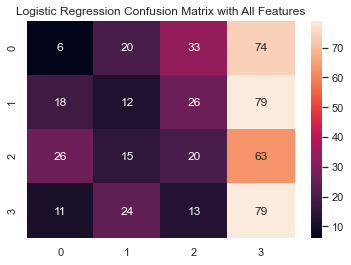

Multinomial Logistic Regression accuracy: 22.54%


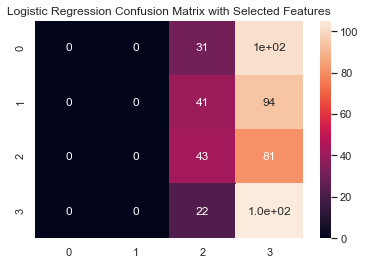

Multinomial Logistic Regression accuracy: 28.52%


In [15]:
lr = train_test_lr(x_train, y_train, x_test, y_test, 
    "Logistic Regression Confusion Matrix with All Features")
lr_selected = train_test_lr(x_train_selected, 
    y_train_selected, x_test_selected, y_test_selected,
    "Logistic Regression Confusion Matrix with Selected Features")

### Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
def train_test_gb(x_train, y_train, x_test, y_test, title):
    classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=5)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)

    plot_confusion_metrics(title, y_test, y_pred)
    print(f"Gradient Boosting accuracy: {compute_score(y_test, y_pred)}%")
    
    return classifier

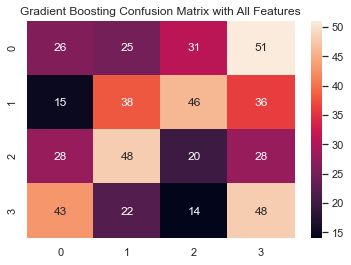

Gradient Boosting accuracy: 25.43%


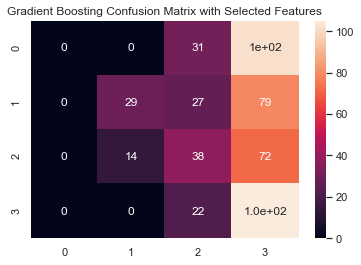

Gradient Boosting accuracy: 33.14%


In [18]:
gb = train_test_gb(x_train, y_train, x_test, y_test, 
    "Gradient Boosting Confusion Matrix with All Features")
gb_selected = train_test_gb(x_train_selected, 
    y_train_selected, x_test_selected, y_test_selected,
    "Gradient Boosting Confusion Matrix with Selected Features")

## Prediction

In [19]:
def predict(model, x_to_be_pred, encoders, label):
    label_encoder = encoders_selected[label]
    value = label_encoder.classes_
    key = label_encoder.transform(value)
    label_mapping = dict(zip(key, value))
    output = []
    for y_pred in model.predict(x_to_be_pred):
        output.append(label_mapping.get(y_pred))
    return output

In [20]:
df_test = pd.DataFrame({"maintenance": ["high"], "number_of_door": [4], 
    "lug_boot_size": ["big"], "safety": ["high"], "class_value": ["good"]})

df_test.head()

,maintenance,number_of_door,lug_boot_size,safety,class_value
0,high,4,big,high,good


In [21]:
x_to_be_pred = preprocessing(df=df_test, features=selected_features, encoders=encoders_selected)

/Users/chongaih.hau/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [22]:
predict(gb_selected, x_to_be_pred, encoders_selected, label)

['med']